### Word Embeddings for Text Classification (Emotion Recognition)

**Task:** Classify text data into different emotions using word embedding and other deep information retrieval approaches.

**Github Repo:** [LINK](https://github.com/omarsar/data_mining_lab_fall_2)

**Dataset: ** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

---

### Requirements:

#### Software:
------------------

* Python 3 (coding will be done strictly using Python)
* Anaconda Environment (recommended but not mandatory) (https://www.continuum.io/downloads)
* Jupyter (http://jupyter.org/)
* Google's word2vec (Download the file... warning! it is really huge)(https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
* Gensim (https://radimrehurek.com/gensim/)
* Scikit Learn (http://scikit-learn.org/stable/) (get the latest version)
* Pandas (http://pandas.pydata.org/)
* Matplotlib (https://matplotlib.org/)
* NLTK (for stopwords) (http://www.nltk.org/)

#### Computing Resources:
-------------------
* Operating System: Preferably Linux or MacOS (Windows break but you can try it out)
* RAM: 4GB 
* Disk Space: 8GB (mostly to store word embeddings)

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from helpers import *

%matplotlib inline

2017-11-19 21:47:52,626 : INFO : 'pattern' package not found; tag filters are not available for English
/home/ellfae/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Exploration

In [3]:
### train data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
train_data = pd.concat([anger_train, fear_train, joy_train, sadness_train])

### test data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
test_data = pd.concat([anger_test, fear_test, joy_test, sadness_test])

In [5]:
# shuffle dataset
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

In [6]:
train_data[0:10]

,id,text,emotion,intensity
617,20617,Recording some more #FNAF and had to FaceTime ...,fear,0.458
992,20992,@darwinwatersons @pennyfitzger31 @gumballwatte...,fear,0.271
144,20144,@Budget car rental you have made realize why ...,fear,0.729
224,20224,Retweeted Dr. Rand Paul (@RandPaul):\n\nStop f...,fear,0.667
385,40385,@SimonSSSJ123 @EllieG10853 @Onision @Eugenia_C...,sadness,0.485
574,10574,@MMASOCCERFAN @outmagazine No offense but the ...,anger,0.417
281,10281,Have wee pop socks on and they KEEP FALLING OF...,anger,0.562
579,30579,@Devilligan It's a beautifully sincere balanci...,joy,0.375
609,10609,I've been wanting salty fries from McDonald's ...,anger,0.396
231,30231,Ryan Gosling and Eva Mendes finally ; B joyfu...,joy,0.620


In [8]:
### Count the number of words in training dataset
train_data['text'].apply(lambda x: len(x.split(' '))).sum()

58792

**Note:** Usually at least 500K words are suggested to train a word2vec model, so performance may not be the best here.

**Exercise 1:** Plot word frequency in both train and test dataset. (Hint: refer to DM lab 1)

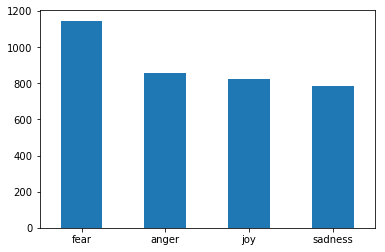

In [11]:
### classes / targets
my_tags = ['sadness', 'fear', 'joy', 'anger']
train_data.emotion.value_counts().plot(kind="bar", rot=0)

**Exercise:** Is this considered an imbalanced dataset? Try to perform some more data exploration and statistical inference as done in lab session 1. 

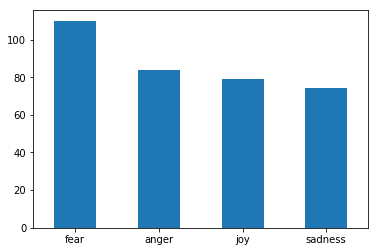

In [12]:
test_data.emotion.value_counts().plot(kind="bar", rot=0)

---
### Train Naive Models (Baselines)
- Bag of words
- N-grams
- TF-IDF

#### Bag of Words
Using scikit-learn CountVectorizer perform word frequency and use these as features to train a model.

In [13]:
# build analyzers
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 

# apply analyzer
train_data_features = count_vectorizer.fit_transform(train_data['text'])

In [17]:
train_data_features.toarray()

array([[0, 2, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [6, 2, 0, ..., 0, 0, 0],
       ..., 
       [1, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 2, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
logreg_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg_model = logreg_model.fit(train_data_features, train_data['emotion'])

In [21]:
# observe some features
count_vectorizer.get_feature_names()[100:110]

['af',
 'affair',
 'affliction',
 'afford',
 'afraid',
 'afternoon',
 'age',
 'agent',
 'ages',
 'aggravate']

accuracy 0.734870317003
confusion matrix
 [[60  6  3 15]
 [10 80  6 14]
 [ 5  9 65  0]
 [ 5 15  4 50]]
(row=expected, col=predicted)


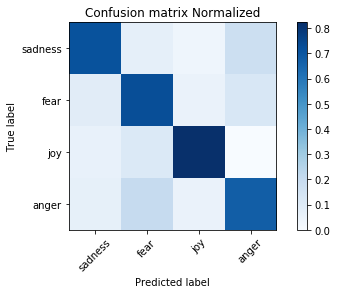

In [22]:
word_embeddings.predict(count_vectorizer, logreg_model, test_data, my_tags)

In [23]:
# words for the emotion of anger
anger_tag_id = word_embeddings.get_tag_index(my_tags, "anger") 
anger_words = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      anger_tag_id, 3000)
anger_words = pd.DataFrame(anger_words)

In [24]:
anger_words[:10]

,0,1
0,sober,32.652855
1,grim,29.568752
2,spent,29.535102
3,stayed,28.740246
4,sunk,28.026766
5,pine,27.139517
6,depress,26.822598
7,depression,26.498302
8,unhappy,26.318313
9,sadly,26.235318


In [25]:
# words for the emotion of fear
fear_tag_id = word_embeddings.get_tag_index(my_tags, "fear") 
fear_words = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      fear_tag_id, 3000)
fear_words = pd.DataFrame(fear_words)

In [26]:
fear_words[:10]

,0,1
0,horror,29.322370
1,concern,28.709943
2,flirting,27.319602
3,shake,25.605281
4,terrorism,25.560661
5,nervous,25.427409
6,horrific,23.865957
7,bully,23.771854
8,jimmy,23.579379
9,rooney,23.255897


In [27]:
# check overlap of words and their index
word_embeddings.check_word_overlap(anger_words[:500][0], fear_words[:500][0])

[[['rich', 27],
  ['idea', 208],
  ['😭', 283],
  ['cold', 332],
  ['finish', 353],
  ['honestly', 360],
  ['plenty', 375],
  ['bake', 383],
  ['childhood', 405],
  ['sue', 447],
  ['definitely', 475],
  ['father', 480],
  ['birth', 483],
  ['red', 488]],
 14]

You may notice that even though the words overlap some of them are not even related to any of the emotions, therefore, we can improve this model. What would happen if we just remove the overlapping words?

#### Character N-grams
A character n-gram is a chunk of a document of length n. It is a poor man's tokenizer but sometimes works well. The parameter n depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones. 3K is a fair comparison since the previous bag of words model was this size as well.

In [28]:
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

charn_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['text'])

charn_model = charn_model.fit(train_data_features, train_data['emotion'])

In [29]:
### observe some features
n_gram_vectorizer.get_feature_names()[100:110]

[' bec',
 ' beca',
 ' bee',
 ' been',
 ' bei',
 ' bein',
 ' bet',
 ' bi',
 ' bl',
 ' bla']

accuracy 0.662824207493
confusion matrix
 [[58  4  9 13]
 [14 71  6 19]
 [10 15 49  5]
 [ 7  9  6 52]]
(row=expected, col=predicted)


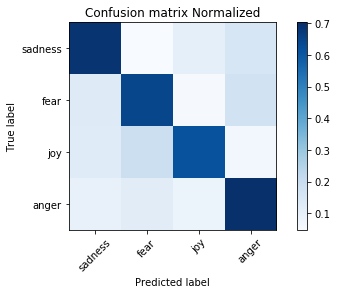

In [30]:
word_embeddings.predict(n_gram_vectorizer, charn_model, test_data, my_tags)

You can notice that the char n-gram model doesn't perform as well as the bag of words model.

**Exercise:** Try to improve the model by removing stopwords; or try other techniques you have learned so far.

#### TF-IDF
Term Frequency - Inverse Document Frequency is useful to rank importance of words to documents

In [31]:
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['text'])

tfidf_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)
tfidf_model = tfidf_model.fit(train_data_features, train_data['emotion'])

In [32]:
tf_vect.get_feature_names()[100:110]

['17',
 '18:41',
 '1nataliemaines',
 '1st',
 '2',
 '2-3',
 '20',
 '2014',
 '2015.',
 '2016']

accuracy 0.798270893372
confusion matrix
 [[62  7  3 12]
 [ 6 89  5 10]
 [ 4  4 69  2]
 [ 6  8  3 57]]
(row=expected, col=predicted)


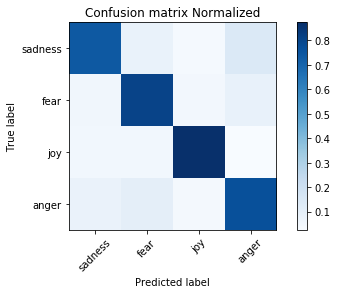

In [33]:
word_embeddings.predict(tf_vect, tfidf_model, test_data, my_tags)

Let us perform some further analysis on the TF-IDF model.

In [34]:
# words for the anger emotion
anger_tag_id = word_embeddings.get_tag_index(my_tags, "anger")
anger_words = word_embeddings.most_influential_words(tfidf_model, tf_vect, anger_tag_id, 3000)
anger_words[0:10]

[['unhappy', 49.125246254034337],
 ['sober', 48.022596096955574],
 ['lost', 46.845720591869181],
 ['pine', 45.987331531830989],
 ['blues', 45.952139717565011],
 ['grim', 45.896981357209285],
 ['stayed', 45.417541326629191],
 ['dark', 44.438956045973413],
 ['dull', 43.812737961256708],
 ['depressing', 43.002286472820778]]

In [35]:
# words for the joy
joy_tag_id = word_embeddings.get_tag_index(my_tags, "joy")
joy_words = word_embeddings.most_influential_words(tfidf_model, tf_vect, joy_tag_id, 3000)
joy_words[0:10]

[['elated', 49.435472553063647],
 ['pleasing', 42.330530868032966],
 ['playful', 42.251062577888234],
 ['animated', 41.807040398506309],
 ['joyous', 40.796975736039876],
 ['rejoicing', 40.583376648348029],
 ['optimism', 39.74570894231055],
 ['hilarious', 39.619336751035114],
 ['cheerfully', 38.552804700392308],
 ['cheering', 38.203363194562726]]

**Exercise:** Head to scikit-learn webiste and learn how to use different parameters for the TF-IDF vectorizer, such as modifying the ngram_range. It might improve the performance of the classifier.

---

### Averaging Word Vectors (word2vec model)

**SOURCE:** https://code.google.com/archive/p/word2vec/

First, we are going to use a pretrained model provided as open source by Google (word2vec)

In [45]:
wv = gensim.models.KeyedVectors.load_word2vec_format(
    "data/google_word2vec/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

2017-11-19 22:38:33,997 : INFO : loading projection weights from data/google_word2vec/GoogleNews-vectors-negative300.bin.gz
2017-11-19 22:40:19,543 : INFO : loaded (3000000, 300) matrix from data/google_word2vec/GoogleNews-vectors-negative300.bin.gz
2017-11-19 22:40:19,543 : INFO : precomputing L2-norms of word weight vectors


**Pre-processing** Here we tokenize both the training and testing datasets before creating the vectors with word2vec. Think of this as a filtering step. In this case words with len(word)<2 are removed.

In [46]:
test_tokenized = test_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['text']), axis=1).values

In [47]:
test_tokenized[0:10]

array([ list(['Dunno', 'am', 'going', 'to', 'the', 'Yorkshire', 'scare', 'grounds', 'when', 'only', 'lasted', 'minute', 'in', 'the', 'Alton', 'towers', 'one', 'before', 'running', 'out', 'fire', 'exit', 'crying']),
       list(['Ananya', 'just', 'grabbed', 'bible', 'opened', 'it', 'started', 'reading', 'and', 'then', 'said', "'where", 'do', 'they', 'talk', 'about', 'burning', 'people']),
       list(['kayleighmcenany', 'DonaldJTrumpJr', 'Is', 'that', 'really', 'all', 'you', 'can', 'offer', 'for', 'those', 'who', 'sacrifice', 'daily', 'to', 'keep', 'you', 'safe', '...', 'kayleighmcenany']),
       list(['incredible', 'that', 'anthony', 'weiner', 'has', 'been', 'caught', 'chasing', 'busty', 'milkmaid', 'across', 'park', 'at', 'double', 'speed', 'while', 'jaunty', 'music', 'plays']),
       list(['This', 'is', 'horrible', 'Lewis', 'Dunk', 'has', 'begun', 'networking', 'Neo-Geo', 'with', 'his', 'holiday', 'home', 'in', 'Mexico']),
       list(['Just', 'seeing', 'Alex', 'revells', 'face', '

Next, we have to convert the words into a distributed representation (in other words, each token must be converted into its vector representation obtained from word2vec). Since we are using a pretrained word2vec the conversion can be done easily. 

Now that we have the word embeddings, we can obtain vectors for an entire document, by averaging word vectors. (Warning: very naive approach!)

![alt txt](https://docs.google.com/drawings/d/1m1Uod7QU4iSN7J3iqsTU6JRWdGTEJRZ2dA7rZrgNHgA/pub?w=942&h=375)

In [48]:
### Here we average the word vectors
X_train_word_average = word2vec_helpers.word_averaging_list(wv,train_tokenized)
X_test_word_average = word2vec_helpers.word_averaging_list(wv,test_tokenized)

In [49]:
X_train_word_average[0]

array([ 0.0828345 , -0.03720188,  0.03113783,  0.09435879, -0.04738354,
       -0.02334516,  0.04464549, -0.08764581,  0.05910314,  0.05702304,
       -0.0381741 , -0.17588666, -0.00759566, -0.01538563, -0.06418473,
        0.0447026 ,  0.10272776,  0.07494403, -0.06186917, -0.07438852,
       -0.00160431,  0.09135552,  0.05929718, -0.00096006,  0.03247862,
       -0.01421031, -0.03617261,  0.03098794,  0.06477017, -0.03398748,
        0.02085624,  0.05060841, -0.05719795, -0.02933487, -0.04135398,
       -0.04650778,  0.03750284, -0.04152595,  0.01536915,  0.08942927,
        0.09623399, -0.11036112,  0.1455759 , -0.02299988, -0.00287363,
        0.05799081, -0.05199031, -0.01896928,  0.08540779,  0.01586382,
       -0.02355479,  0.03279874,  0.00465961,  0.03000174, -0.03700826,
        0.0488888 , -0.04989709, -0.06193588,  0.06018326, -0.08827129,
       -0.02334823,  0.04257724, -0.05347706, -0.04378926, -0.05149174,
        0.00481888, -0.04781246,  0.08248097, -0.01080719,  0.06

**Further exploration of word2vec generated vectors**

Some tips here: https://radimrehurek.com/gensim/models/keyedvectors.html

In [51]:
### obtain vector for a specific word
wv.syn0norm[wv.vocab['unhappy'].index] # (300,)

array([  7.44407773e-02,   5.99248260e-02,  -1.14452699e-02,
        -9.60286036e-02,  -6.58800900e-02,   8.22570622e-02,
         3.55454721e-02,  -1.34923914e-02,   6.36468679e-02,
         9.82618257e-02,  -4.52227741e-02,  -9.44467355e-03,
        -3.59176770e-02,   4.80143018e-02,  -3.16373296e-02,
         5.06197289e-02,   7.18353540e-02,   1.92615520e-02,
         2.38210484e-02,  -8.88636801e-03,  -2.18669791e-02,
         8.93289372e-02,   1.46090025e-02,   1.07008619e-02,
         1.19105242e-01,   4.76420969e-02,   7.58365449e-03,
         1.37715442e-02,   9.04455483e-02,  -5.84360100e-02,
         6.21580519e-02,  -3.23817395e-02,   5.54583818e-02,
         9.49119963e-03,   1.11661166e-01,  -8.33736733e-02,
         9.67730135e-02,   3.25678401e-02,  -3.85231040e-02,
         4.24312428e-02,   3.77786942e-02,  -1.43298497e-02,
        -7.67670525e-03,  -8.52346942e-02,  -5.21085449e-02,
        -1.04961500e-01,  -4.42922637e-02,   3.59176770e-02,
        -7.22075552e-02,

Other fun operations you can do with word2vec model

In [52]:
wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118191719055176),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

In [53]:
wv.most_similar(positive=['GOP', 'Trump'], negative=['money'])

[('Republican', 0.571267306804657),
 ('Republicans', 0.5465080738067627),
 ('Donald_Trump', 0.5382609367370605),
 ('Gingrich', 0.5238125324249268),
 ('Palin', 0.5126574635505676),
 ('Santorum', 0.4977916479110718),
 ('Dems', 0.49728360772132874),
 ('Democratic', 0.49602842330932617),
 ('GOPers', 0.49341505765914917),
 ('Democrats', 0.4912267029285431)]

**Exercise:** Try to research mode about the intuition behind these operations and try to come up with more interesting ones.

For fun, let us try to manually compute the cosine similarity of some of our word vectors, which is computed as follows:

![alt txt](https://docs.google.com/drawings/d/1QI_5_uxopOYgk2PzU_RMTUGKkoNhJp81aIz4SUwsHIM/pub?w=956&h=263)

In [59]:
word_embeddings.cosine_measure(wv.syn0norm[wv.vocab['gun'].index], wv.syn0norm[wv.vocab['pistol'].index])

0.76924075586436913

**Exercise:** Try to find cosine similarity between emotion related words. 

---

### KNN Classification

Now we train a KNN and a logistic regression classifier and observe how they perfom on these word-averaging document features

Read about KNN- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

![alt txt](https://docs.google.com/drawings/d/13xu1RP3pVem277_eT900af7iz_MvTQUrLoxzWAewb_o/pub?w=817&h=614)

In [60]:
### train model
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.emotion)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [61]:
### obtain predictions on test data
predicted = knn_naive_dv.predict(X_test_word_average)

accuracy 0.394812680115
confusion matrix
 [[38 29  9  8]
 [35 52 12 11]
 [20 19 29 11]
 [28 16 12 18]]
(row=expected, col=predicted)


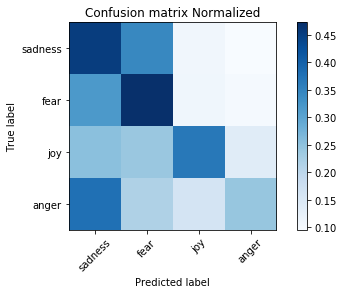

In [63]:
### evaluate the model
word_embeddings.evaluate_prediction(predicted, test_data.emotion, my_tags)

You can see that K-Neareset Neighbour doesn't perform well when using the average vector representations (obtained from pretrained word2vec) of the text data. This is partly because the pretrained word2vec may not be helping with the task at hand. What if we train our own word2vec using our dataset? (We need a lot of data!)

In [64]:
test_data.iloc()[56]['text']

"I can't WAIT to go to work tomorrow with a high as fuck fever. [sarcasm]\\nHopefully I'll feel better tomorrow.\\nBut I doubt it. #pessimism"

In [65]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('anyway', 0.6451989412307739),
 ('do', 0.637501060962677),
 ('just', 0.6333133578300476),
 ('maybe', 0.6231459379196167),
 ('guess', 0.6176087856292725),
 ('it', 0.614241361618042),
 ('suppose', 0.6105259656906128),
 ('so', 0.6092208623886108),
 ('think', 0.6042969822883606),
 ("'ll", 0.5944103002548218),
 ('want', 0.5808286666870117),
 ('probably', 0.5804653167724609),
 ('really', 0.5771951675415039),
 ('know', 0.576975405216217),
 ('going', 0.5763067603111267),
 ('yeah', 0.5684106349945068),
 ('I', 0.5659971237182617),
 ('go', 0.5607538223266602),
 ('even', 0.560643196105957),
 ('if', 0.5593100190162659)]

The problem with the result is that the average of this particular document falls under some area that is not related to the overall emotion portrayed by the original document.

**Exercise:** Try to remove stopwords. Try to figure out how you would achieve this using the current implementation of the *w2v_tokenize_text* function. Also, report the accuracy you achieved.

**Exercise:** Head on over to the Gensim website and figure out how to train a wordvec on your own using the gensim library. 

---

### Doc2Vec
Paper: https://cs.stanford.edu/~quocle/paragraph_vector.pdf
It is a **semi-supervised** approach since a **weak label or tag** (you can put many) is introduced into training documents before modeling. Read more about semi-supervised appraoches here: https://en.wikipedia.org/wiki/Semi-supervised_learning

![alt txt](https://docs.google.com/drawings/d/1TT6jNhk8rVoWMQajb8AIXCtyug0t_YVVZrvFidDPUPU/pub?w=679&h=375)

In [67]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [70]:
### First we tag each text with its emotion
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['text']), tags=[r.emotion]), axis=1)

In [71]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['text']), tags=[r.emotion]), axis=1)

In [72]:
test_tagged.values[50]

TaggedDocument(words=['chutneysupercat', 'hi', 'lovely', 'brownie', 'mm', 'is', 'calling', 'me', 'tuppytupperware..', 'its', 'awful'], tags=['fear'])

In [73]:
# transform into proper format
trainsent = train_tagged.values
testsent = test_tagged.values

In [75]:
trainsent

array([ TaggedDocument(words=['recording', 'some', 'more', 'fnaf', 'and', 'had', 'to', 'facetime', 'my', 'mum', 'to', 'let', 'her', 'know', 'was', 'okay', 'after', 'let', 'out', 'high', 'pitched', 'scream', 'suchagirl'], tags=['fear']),
       TaggedDocument(words=['darwinwatersons', 'pennyfitzger31', 'gumballwatter15', 'ok', 'but', 'why', 'tomorrow', 'horrible', 'day', 'my', 'day', 'was', 'great'], tags=['fear']),
       TaggedDocument(words=['budget', 'car', 'rental', 'you', 'have', 'made', 'realize', 'why', 'always', 'use', 'nationalcares', 'what', 'nightmare', 'disgusted'], tags=['fear']),
       ...,
       TaggedDocument(words=['lennyabrahamson', 'may', 'send', 'you', 'copy', 'of', 'herothegreyhound', 'either', 'e-book', 'or', 'real', 'paper', 'one', 'boy', 'and', 'greyhound', 'smiles', 'tears'], tags=['joy']),
       TaggedDocument(words=['regret', 'for', 'the', 'things', 'we', 'did', 'can', 'be', 'tempered', 'by', 'time', 'it', 'is', 'regret', 'for', 'the', 'things', 'we', 'did

In [76]:
# train the model with simple gensim doc2vec api
# size (dimensions of features)
# dm is the training algorithm (distribute memory (1) or distributed bag of words)
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-11-19 23:12:39,197 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-11-19 23:12:39,198 : INFO : collecting all words and their counts
2017-11-19 23:12:39,198 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-11-19 23:12:39,219 : INFO : collected 10719 word types and 4 unique tags from a corpus of 3613 examples and 56393 words
2017-11-19 23:12:39,220 : INFO : Loading a fresh vocabulary
2017-11-19 23:12:39,225 : INFO : min_count=5 retains 1361 unique words (12% of original 10719, drops 9358)
2017-11-19 23:12:39,225 : INFO : min_count=5 leaves 42365 word corpus (75% of original 56393, drops 14028)
2017-11-19 23:12:39,228 : INFO : deleting the raw counts dictionary of 10719 items
2017-11-19 23:12:39,229 : INFO : sample=0.001 downsamples 63 most-common words
2017-11-19 23:12:39,230 : INFO : downsampling leaves estimated 31357 word corpus (74.0% of prior 42365)
2017-11-19 23:12:39,230 : INFO : estimated required m

In [77]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

Let us see what our data looks like after training and transormations

In [79]:
test_targets[0:5]

('fear', 'anger', 'sadness', 'joy', 'fear')

In [80]:
test_regressors[0:5]

(array([-0.39524838, -0.08373364, -0.14480482,  0.27350155,  0.20739011], dtype=float32),
 array([-0.37708506, -0.2205207 ,  0.30018979,  0.21298207, -0.10291009], dtype=float32),
 array([-0.10260689,  0.04069313,  0.1139339 ,  0.16602848, -0.02557355], dtype=float32),
 array([-0.4432691 ,  0.125214  , -0.04396084,  0.25234041,  0.12425233], dtype=float32),
 array([ 0.09505802,  0.09512238, -0.03159134,  0.17345698,  0.09683908], dtype=float32))

In [82]:
# train a logistic regression model
d2v_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)
d2v_model = d2v_model.fit(train_regressors, train_targets)

accuracy 0.590778097983
confusion matrix
 [[40 25  9 10]
 [15 77 11  7]
 [ 6 14 50  9]
 [10 16 10 38]]
(row=expected, col=predicted)


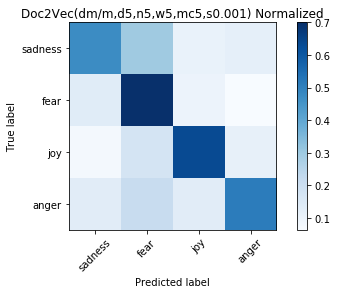

In [83]:
word_embeddings.evaluate_prediction(d2v_model.predict(test_regressors), test_targets, my_tags,title=str(doc2vec_model))

Now let us train KNN model with doc2vec.

2017-11-19 23:15:05,294 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.590778097983
confusion matrix
 [[38 18 15 13]
 [14 72 15  9]
 [ 6 10 54  9]
 [ 6 11 16 41]]
(row=expected, col=predicted)


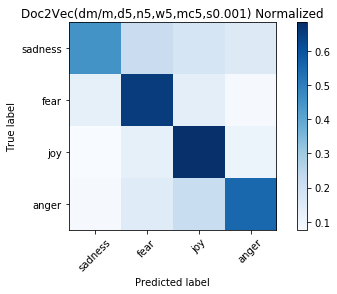

In [85]:
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
word_embeddings.evaluate_prediction(knn_test_predictions, test_targets,my_tags, str(doc2vec_model))

Since doc2vec also gives us a vector for each genre, we can also observe which genres are similar to each other

In [86]:
doc2vec_model.docvecs.most_similar('anger')

[('sadness', 0.2729802429676056),
 ('fear', 0.247198224067688),
 ('joy', 0.2352927327156067)]

In [87]:
doc2vec_model.docvecs.most_similar('fear')

[('sadness', 0.3019334375858307),
 ('anger', 0.2471982091665268),
 ('joy', 0.23824873566627502)]

Since words and categories fall in the same vector space, it is possible to also observe which words sorround a tag. Notice how well those words describe the tag.

In [89]:
doc2vec_model.most_similar([doc2vec_model.docvecs['joy']])

[('strength', 0.9957280158996582),
 ('gloomy', 0.978492021560669),
 ('beautiful', 0.9719856977462769),
 ('present', 0.9529615640640259),
 ('lol', 0.9487402439117432),
 ('thenicebot', 0.948267936706543),
 ('letting', 0.9436185359954834),
 ('haunt', 0.9382511377334595),
 ('accept', 0.9362047910690308),
 ('chirp', 0.9357328414916992)]

### Visualization
We will visualize embeddings using a popular algorithm called T-SNE, which is very similar to the dimentionality reduction algorithm called PCA.

In [90]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [92]:
### unpacking words from the dco2vec model trained
doc2vec_words = word2vec_helpers.unpack_words_from_doc_vector(doc2vec_model)

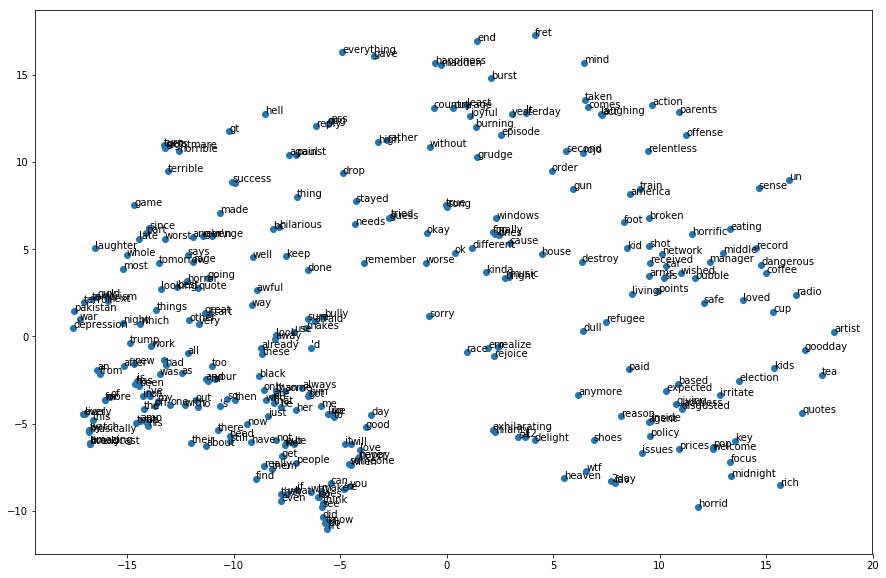

In [93]:
word2vec_helpers.visualize_vectors(doc2vec_model, doc2vec_words)

**Exercise:** Try to visualize words and find interesting clusters. There are so many creative ways to visualize these powerful vector representations. You can also try other type of classifiers and apply other improvements in the preprocessing stages.